In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crimedataset-leicester-humberside/2022-06-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2022-10-leicestershire-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-02-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-03-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2022-09-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-03-leicestershire-street.csv
/kaggle/input/crimedataset-leicester-humberside/2022-03-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2022-07-leicestershire-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-01-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-01-leicestershire-street.csv
/kaggle/input/crimedataset-leicester-humberside/2022-12-humberside-street.csv
/kaggle/input/crimedataset-leicester-humberside/2023-02-leicestershire-street.csv
/kaggle/input/crimedataset-leicester-humbers

In [2]:
# install PySpark 
#http://spark.apache.org/docs/latest/api/python/index.html

!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 11.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=2d94a59abfe47277668c3f75cbb86e8cbace08d3547dd642874bb7e7fa8fe509
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# start spark sessnon and configureation
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/22 00:50:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [5]:
#create leicestercrime dataFrame directly from CRIME DATASET LEICESTER AND HUMBERSIDE csv file 
#https://data.police.uk/data/

LeicesterCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/crimedataset-leicester-humberside/*leicestershire-street.csv")

In [6]:
# create humberside dataframe

HumbersideCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/crimedataset-leicester-humberside/*humberside-street.csv")

In [7]:
LeicesterCrime.printSchema()
HumbersideCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (null

In [8]:
# tidy up the column names

LeicesterCrime = LeicesterCrime.withColumnRenamed('Crime ID', 'Crime_ID')
LeicesterCrime = LeicesterCrime.withColumnRenamed('Reported by', 'Reported_by')
LeicesterCrime = LeicesterCrime.withColumnRenamed('Falls within', 'Falls_within')
LeicesterCrime = LeicesterCrime.withColumnRenamed('LSOA code', 'LSOA_code')
LeicesterCrime = LeicesterCrime.withColumnRenamed('LSOA name', 'LSOA_name')
LeicesterCrime = LeicesterCrime.withColumnRenamed('Crime type', 'Crime_type')
LeicesterCrime = LeicesterCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

HumbersideCrime = HumbersideCrime.withColumnRenamed('Crime ID', 'Crime_ID')
HumbersideCrime = HumbersideCrime.withColumnRenamed('Reported by', 'Reported_by')
HumbersideCrime = HumbersideCrime.withColumnRenamed('Falls within', 'Falls_within')
HumbersideCrime = HumbersideCrime.withColumnRenamed('LSOA code', 'LSOA_code')
HumbersideCrime = HumbersideCrime.withColumnRenamed('LSOA name', 'LSOA_name')
HumbersideCrime = HumbersideCrime.withColumnRenamed('Crime type', 'Crime_type')
HumbersideCrime = HumbersideCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')


In [9]:
LeicesterCrime.printSchema()
HumbersideCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (null

In [10]:
LeicesterCrime.take(2)
LeicesterCrime.head(2)
HumbersideCrime.take(2)

[Row(Crime_ID='9f580a56412ca35cbda5cd24751f2bbebccde473b5de86d1350359785fa4c55e', Month='2023-03', Reported_by='Humberside Police', Falls_within='Humberside Police', Longitude=-0.560442, Latitude=52.042533, Location='On or near Station Road', LSOA_code='E01017416', LSOA_name='Central Bedfordshire 009A', Crime_type='Violence and sexual offences', Last_outcome_category='Under investigation', Context=None),
 Row(Crime_ID='9ac05443dbc2cb33e2c8c8a4c9d24c1e69335457efdd34768537c949d070209b', Month='2023-03', Reported_by='Humberside Police', Falls_within='Humberside Police', Longitude=-1.130754, Latitude=53.519017, Location='On or near ', LSOA_code='E01007645', LSOA_name='Doncaster 022E', Crime_type='Vehicle crime', Last_outcome_category='Investigation complete; no suspect identified', Context=None)]

In [11]:
#get the counts for each month ordered in descending order
LeicesterCrime_month= LeicesterCrime.groupby("Month").count().orderBy(desc("count")).withColumnRenamed("count", "Leicester_City_Crime_Count")
LeicesterCrime_month.show()

HumbersideCrime_month=HumbersideCrime.groupby("Month").count().orderBy(desc("count")).withColumnRenamed("count", "Humberside_City_Crime_Count")
HumbersideCrime_month.show()

+-------+--------------------------+
|  Month|Leicester_City_Crime_Count|
+-------+--------------------------+
|2022-08|                     10373|
|2022-05|                     10332|
|2022-07|                     10056|
|2022-03|                     10019|
|2022-06|                      9980|
|2022-11|                      9816|
|2022-10|                      9802|
|2023-03|                      9591|
|2022-04|                      9494|
|2022-09|                      9492|
|2023-02|                      8793|
|2023-01|                      8676|
|2022-12|                      8603|
+-------+--------------------------+

+-------+---------------------------+
|  Month|Humberside_City_Crime_Count|
+-------+---------------------------+
|2023-03|                       9285|
|2022-08|                       9161|
|2022-03|                       9019|
|2022-04|                       8964|
|2022-07|                       8852|
|2022-06|                       8798|
|2022-10|                   

In [12]:
LeicesterCrime_month.printSchema()

HumbersideCrime_month.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Leicester_City_Crime_Count: long (nullable = false)

root
 |-- Month: string (nullable = true)
 |-- Humberside_City_Crime_Count: long (nullable = false)



In [13]:
LeicesterCrime_month.orderBy(desc("Month")).show()

HumbersideCrime_month.orderBy(desc("Month")).show()

+-------+--------------------------+
|  Month|Leicester_City_Crime_Count|
+-------+--------------------------+
|2023-03|                      9591|
|2023-02|                      8793|
|2023-01|                      8676|
|2022-12|                      8603|
|2022-11|                      9816|
|2022-10|                      9802|
|2022-09|                      9492|
|2022-08|                     10373|
|2022-07|                     10056|
|2022-06|                      9980|
|2022-05|                     10332|
|2022-04|                      9494|
|2022-03|                     10019|
+-------+--------------------------+

+-------+---------------------------+
|  Month|Humberside_City_Crime_Count|
+-------+---------------------------+
|2023-03|                       9285|
|2023-02|                       8569|
|2023-01|                       8583|
|2022-12|                       7339|
|2022-11|                       8026|
|2022-10|                       8714|
|2022-09|                   

In [14]:
#retrieve yearly amount of crimes sorted descendantly

LeicesterCrime_year=LeicesterCrime.select(substring(LeicesterCrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).withColumnRenamed("count", "Leicester_City_Crime_Count")
LeicesterCrime_year.show()

HumbersideCrime_year=HumbersideCrime.select(substring(HumbersideCrime.Month, 1, 4).alias('Year'), "Month") \
    .groupby("Year").count().orderBy(desc("count")).withColumnRenamed("count", "Humberside_City_Crime_Count")
HumbersideCrime_year.show()

+----+--------------------------+
|Year|Leicester_City_Crime_Count|
+----+--------------------------+
|2022|                     97967|
|2023|                     27060|
+----+--------------------------+

+----+---------------------------+
|Year|Humberside_City_Crime_Count|
+----+---------------------------+
|2022|                      85723|
|2023|                      26437|
+----+---------------------------+



In [15]:
#register temp tables for Leicester and Humberside
LeicesterCrime.registerTempTable("temp_LeicesterCrimes")
HumbersideCrime.registerTempTable("temp_HumbersideCrimes")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [16]:
sqlContext.sql("select * from temp_LeicesterCrimes").show(5)
sqlContext.sql("select * from temp_HumbersideCrimes").show(5)


+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code| LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|f452c4f173253a904...|2022-05|Leicestershire Po...|Leicestershire Po...|-1.214768|52.622431|On or near Queens...|E01025631|Blaby 002A|            Burglary| Status update una...|   null|
|7e8c156f99e28cf26...|2022-05|Leicestershire Po...|Leicestershire Po...|-1.214176|52.621663|On or near Lowlan...|E01025631|Blaby 002A|        Public order| Investigation com...|   null|
|92068d66fa7c47414...|2022-05|Leicestershire Po...|Leicestershire Po..

In [17]:
#retreive monthly crime amount of Leicester and order by total in descending order
sqlContext.sql("select * from temp_LeicesterCrimes order by Month desc").show(5)

#retreive monthly crime amount of Humberside and order by total in descending order
sqlContext.sql("select * from temp_HumbersideCrimes order by Month desc").show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code| LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|                null|2023-03|Leicestershire Po...|Leicestershire Po...|-1.211133| 52.61917|On or near Cox Me...|E01025631|Blaby 002A|Anti-social behav...|                 null|   null|
|f1c4554c2174d33a4...|2023-03|Leicestershire Po...|Leicestershire Po...| -1.21709|52.620623|         On or near |E01025631|Blaby 002A|        Public order|  Under investigation|   null|
|817973b6623781447...|2023-03|Leicestershire Po...|Leicestershire Po..

In [18]:
LeicesterCrime_month.registerTempTable("tbl_LeicesterCrimes")

HumbersideCrime_month.registerTempTable("tbl_HumbersideCrimes")

In [19]:
# Create new dataframe with month, total, and averages
avgCrimeAmount_Leicester = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(Leicester_City_Crime_Count) as Total, avg(Leicester_City_Crime_Count) as \
Average from tbl_LeicesterCrimes group by substring(Month, 6, 2)").orderBy('Month')
avgCrimeAmount_Leicester.show()

avgCrimeAmount_Humber = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(Humberside_City_Crime_Count) as Total, avg(Humberside_City_Crime_Count) as \
Average from tbl_HumbersideCrimes group by substring(Month, 6, 2)").orderBy('Month')
avgCrimeAmount_Humber.show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01| 8676| 8676.0|
|   02| 8793| 8793.0|
|   03|19610| 9805.0|
|   04| 9494| 9494.0|
|   05|10332|10332.0|
|   06| 9980| 9980.0|
|   07|10056|10056.0|
|   08|10373|10373.0|
|   09| 9492| 9492.0|
|   10| 9802| 9802.0|
|   11| 9816| 9816.0|
|   12| 8603| 8603.0|
+-----+-----+-------+

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01| 8583| 8583.0|
|   02| 8569| 8569.0|
|   03|18304| 9152.0|
|   04| 8964| 8964.0|
|   05| 8694| 8694.0|
|   06| 8798| 8798.0|
|   07| 8852| 8852.0|
|   08| 9161| 9161.0|
|   09| 8156| 8156.0|
|   10| 8714| 8714.0|
|   11| 8026| 8026.0|
|   12| 7339| 7339.0|
+-----+-----+-------+



In [20]:
# Register the monthlyCrimeAmount 
# DataFrame as a temp table and show the contents
avgCrimeAmount_Leicester.registerTempTable("avgCrimeAmount_Leicester")
sqlContext.sql("select * from avgCrimeAmount_Leicester")

avgCrimeAmount_Humber.registerTempTable("avgCrimeAmount_Humber")
sqlContext.sql("select * from avgCrimeAmount_Humber")

DataFrame[Month: string, Total: bigint, Average: double]

In [21]:
# Prepare variables for visualisations

Leicester_monthArray = sqlContext.sql("select Month from avgCrimeAmount_Leicester")\
.rdd.map(lambda f:f[0]).collect()
Leicester_monthTotalArray = sqlContext.sql("select Total from avgCrimeAmount_Leicester")\
.rdd.map(lambda f:f[0]).collect()
Leicester_monthAvgArray = sqlContext.sql("select Average from avgCrimeAmount_Leicester")\
.rdd.map(lambda f:f[0]).collect()


Humber_monthArray = sqlContext.sql("select Month from avgCrimeAmount_Humber")\
.rdd.map(lambda f:f[0]).collect()
Humber_monthTotalArray = sqlContext.sql("select Total from avgCrimeAmount_Humber")\
.rdd.map(lambda f:f[0]).collect()
Humber_monthAvgArray = sqlContext.sql("select Average from avgCrimeAmount_Humber")\
.rdd.map(lambda f:f[0]).collect()

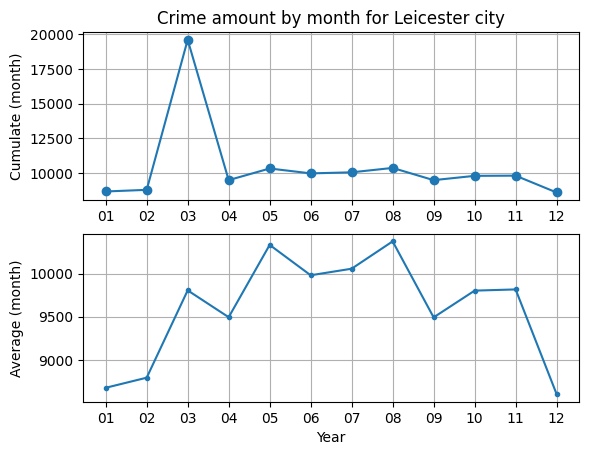

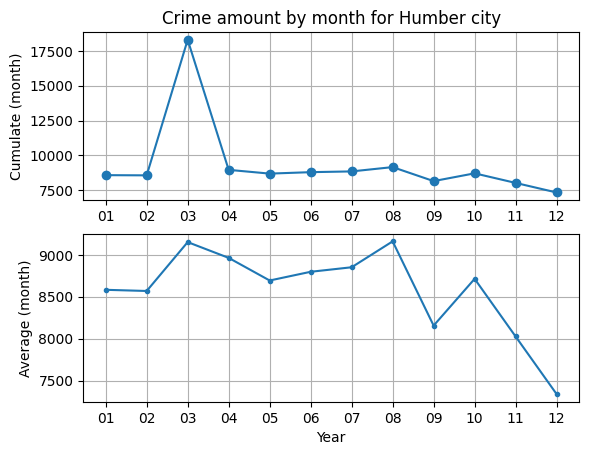

In [22]:
# Plot visualisations for Leiceter city 

import matplotlib.pyplot as plt
import numpy as np

y1 = Leicester_monthArray
t1 = Leicester_monthTotalArray
a1 = Leicester_monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y1, t1, 'o-')
plt.title('Crime amount by month for Leicester city')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y1, a1, '.-')
plt.xlabel('Year')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()


# Plot visualisations for Humber city 

import matplotlib.pyplot as plt
import numpy as np

y = Humber_monthArray
t = Humber_monthTotalArray
a = Humber_monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by month for Humber city')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount2.png")
plt.show()


In [23]:
# # Register the monthlyCrimeAmount 
# # DataFrame as a temp table and show the contents
# yearLeicester.registerTempTable("yearLeicester")
# spark.sql("select * from yearLeicester")

# yearHumber.registerTempTable("yearHumber")
# sqlContext.sql("select * from yearHumber")

In [24]:
# # Prepare variables for visualisations

# LeicesYeartotalArray = sqlContext.sql("select Total from yearLeicester")\
# .rdd.map(lambda f:f[0]).collect()
# LeicesyearArray = sqlContext.sql("select Year from yearLeicester")\
# .rdd.map(lambda f:f[0]).collect()
# LeicesaverageArray = sqlContext.sql("select Average from yearLeicester")\
# .rdd.map(lambda f:f[0]).collect()

# HumberYeartotalArray = sqlContext.sql("select Total from yearHumber")\
# .rdd.map(lambda f:f[0]).collect()
# HumberyearArray = sqlContext.sql("select Year from yearHumber")\
# .rdd.map(lambda f:f[0]).collect()
# HumberaverageArray = sqlContext.sql("select Average from yearHumber")\
# .rdd.map(lambda f:f[0]).collect()

In [25]:
# # Plot visualisations for Leicester city
# import matplotlib.pyplot as plt
# import numpy as np

# y2 = LeicesYeartotalArray
# t2 = LeicesyearArray
# #a2 = LeicesaverageArray

# plt.subplot(2, 1, 1)
# plt.plot(t2, y2, 'o-')
# plt.title('Crime amount by year (2022-03 to 2023-03) for Leicester city')
# plt.ylabel('Cumulate (year)')
# plt.grid(True)
# plt.show()


# # Plot visualisations for Humber city
# import matplotlib.pyplot as plt
# import numpy as np

# y3 = HumberYeartotalArray
# t3 = HumberyearArray
# #a3 = HumberaverageArray

# plt.subplot(2, 1, 1)
# plt.plot(t3, y3, 'o-')
# plt.title('Crime amount by year (2022-03 to 2023-03) for Humber city')
# plt.ylabel('Cumulate (year)')
# plt.grid(True)
# plt.show()

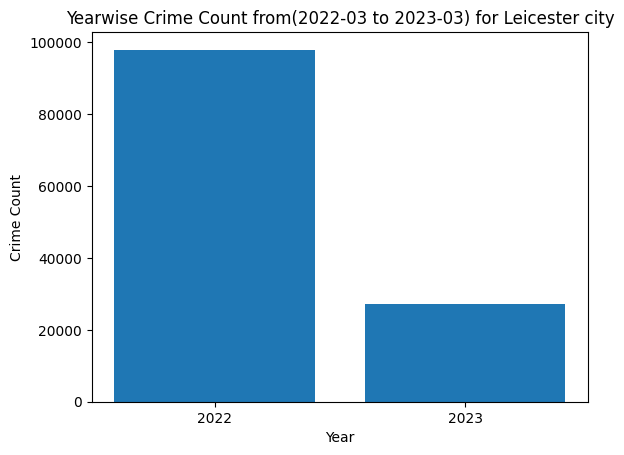

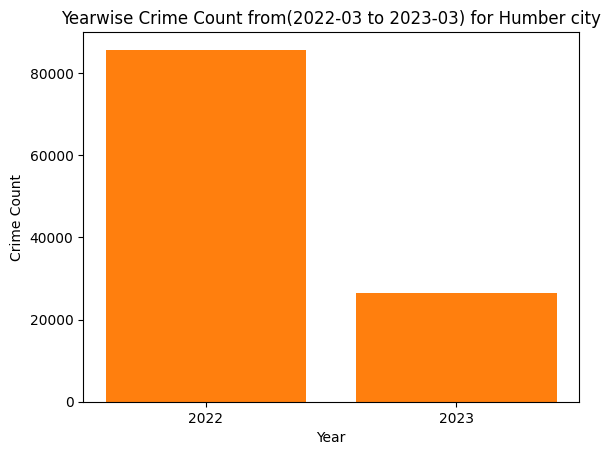

In [26]:
from pyspark.sql.functions import substring
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1

# Extract year from Month column
LeicesterCrime = LeicesterCrime.withColumn("Year", substring(LeicesterCrime.Month, 1, 4))
HumbersideCrime = HumbersideCrime.withColumn("Year", substring(HumbersideCrime.Month, 1, 4))

# Group by Year and count crimes
year_counts1 = LeicesterCrime.groupBy("Year").count().orderBy("Year")
year_counts2 = HumbersideCrime.groupBy("Year").count().orderBy("Year")

# Extract year and count data
years1 = [row.Year for row in year_counts1.collect()]
crime_counts1 = [row["count"] for row in year_counts1.collect()]

years2 = [row.Year for row in year_counts2.collect()]
crime_counts2 = [row["count"] for row in year_counts2.collect()]

# Create bar graph
plt1.bar(years1, crime_counts1)
plt1.xlabel('Year')
plt1.ylabel('Crime Count')
plt1.title('Yearwise Crime Count from(2022-03 to 2023-03) for Leicester city')
plt1.show()

plt.bar(years2, crime_counts2)
plt.bar(years2, crime_counts2)
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Yearwise Crime Count from(2022-03 to 2023-03) for Humber city')
plt.show()


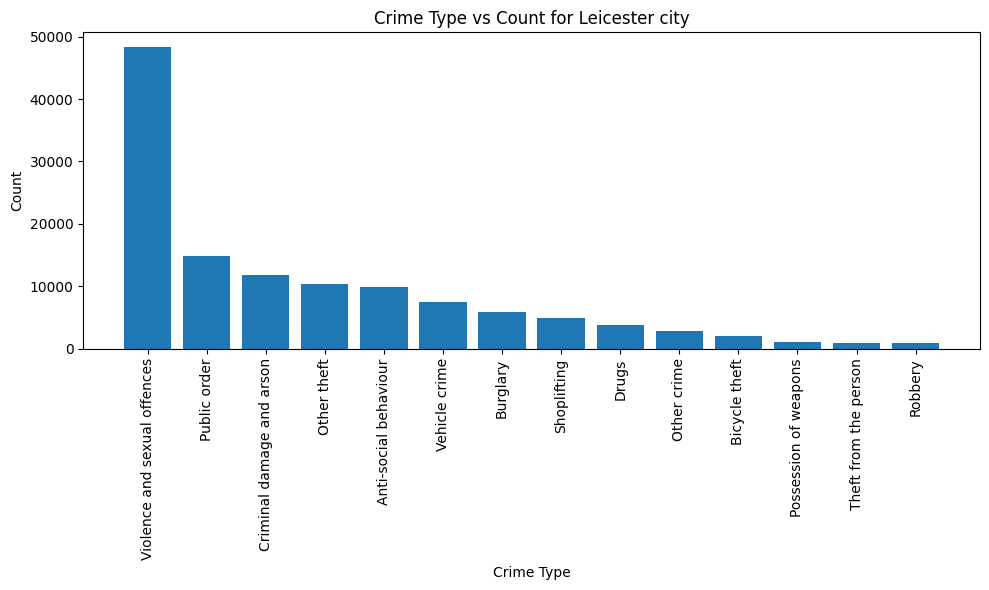

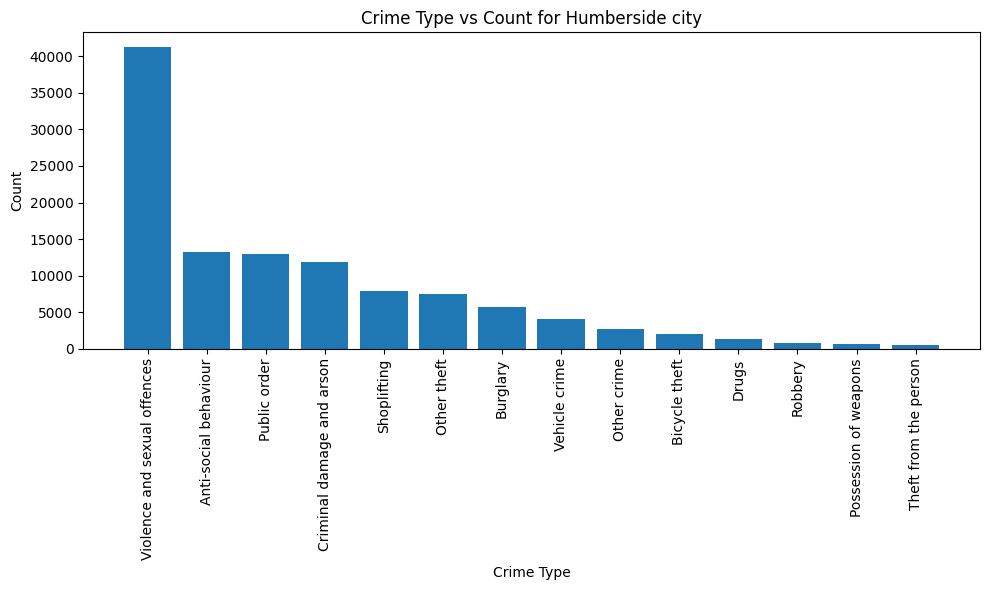

In [27]:
import matplotlib.pyplot as plt

# Aggregate and group data by crime type
crime_counts = LeicesterCrime.groupBy("Crime_type").count().orderBy(desc("count")).collect()

# Extract crime types and counts
crime_types = [row["Crime_type"] for row in crime_counts]
crime_counts = [row["count"] for row in crime_counts]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(crime_types, crime_counts)
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.title("Crime Type vs Count for Leicester city")
plt.xticks(rotation=90)
plt.tight_layout()

# Display the graph
plt.show()

import matplotlib.pyplot as plt

# Aggregate and group data by crime type
crime_counts = HumbersideCrime.groupBy("Crime_type").count().orderBy(desc("count")).collect()

# Extract crime types and counts
crime_types = [row["Crime_type"] for row in crime_counts]
crime_counts = [row["count"] for row in crime_counts]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(crime_types, crime_counts)
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.title("Crime Type vs Count for Humberside city")
plt.xticks(rotation=90)
plt.tight_layout()

# Display the graph
plt.show()

In [28]:
pip install -U seaborn

Note: you may need to restart the kernel to use updated packages.


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for Leicester city
leicester_locations = LeicesterCrime.select("Latitude", "Longitude").toPandas()

# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.histplot2d(
    leicester_locations["Longitude"],
    leicester_locations["Latitude"],
    cmap="YlOrRd",
    cbar=True,
    alpha=0.6,
    bins=100,
    pthresh=0.05,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Location-wise Heatmap for Leicester")
plt.tight_layout()

# Display the plot
plt.show()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


AttributeError: module 'seaborn' has no attribute 'histplot2d'

<Figure size 1000x800 with 0 Axes>